<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_all_mpnet_base_v2_positional_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data, SBERT (all-mpnet-base-v2) and positional encoding

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.

The features are generated by a SBERT/all-mpnet-base-v2 model to represent the documents' sentences. The final features are enriched with positional encoding values in a similar way as the Transformer architecture. In this case, we use the position of each sentence in its document to compute the positional embedding.


### Notebook parameters

In [1]:
model_id = 'sentence-transformers/all-mpnet-base-v2'

###Installing dependencies

In [2]:
# SBERT
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 4.2 MB 26.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.8 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 6.6 MB 35.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=2fa297f05d769e2cd6a92a1912fb3f1fbd40601da8f207bbf5bd001c352a749f
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"
dataset_dir = 'fact_extraction_AILA/'

Mounted at /content/gdrive


In [4]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}{dataset_dir}train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}{dataset_dir}test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

rm: cannot remove 'data': No such file or directory


In [5]:
import pandas as pd
from os import listdir
import csv

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        quoting=csv.QUOTE_NONE, 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


###Features

In [6]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer(model_id)
sent_encoder.max_seq_length = 512

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [7]:
import torch
import numpy as np

torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getPositionEncoding(seq_len, d, n=10000):
  """
  Returns a positional encoding matrix.
  Code adapted from https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
  Arguments:
    seq_len : the length of the sequence.
    d : the embedding / encoding dimension.
  Returns:
    A PyTorch tensor with shape (seq_len, d).
  """
  P = torch.zeros((seq_len, d), device=torch_device)
  for k in range(seq_len):
    for i in torch.arange(int(d/2)):
      denominator = np.power(n, 2*i/d)
      P[k, 2*i] = np.sin(k/denominator)
      P[k, 2*i+1] = np.cos(k/denominator)
  return P

In [8]:
def get_features(dic_docs):
  """
  Generates the features for a set of documents.
  Arguments:
    dic_docs : a dictionary as returned by the read_docs function.
  Returns:
    - The features as a numpy matrix. Each line in the matrix is respective to a sentence.
    - A list of strings with respective sentences' labels.
    - A dictionary associating each document with its features. The key is the 
    document ID and the value is a numpy matrix.
  """
  features = None
  labels = []
  features_by_doc = {}
  for doc_id, df in dic_docs.items():
    sentences = df['sentence'].to_list()
    embedding = sent_encoder.encode(sentences, convert_to_tensor=True)
    embedding = embedding + getPositionEncoding(embedding.shape[0], embedding.shape[1])
    features_by_doc[doc_id] = embedding
    if features is None:
      features = embedding
    else:
      features = torch.vstack((features, embedding))
    labels.extend(df['label'].tolist())
  for doc_id, tensor in features_by_doc.items():
    features_by_doc[doc_id] = tensor.detach().to('cpu').numpy()
  return features.detach().to('cpu').numpy(), labels, features_by_doc

In [9]:
%%time
# Train features
train_features, train_targets, docs_train_features = get_features(docs_train)
print(f'{train_features.shape[0]} sentences.')
print(f'Train features shape: {train_features.shape}')

9380 sentences.
Train features shape: (9380, 768)
CPU times: user 14min 30s, sys: 3.8 s, total: 14min 34s
Wall time: 14min 43s


In [10]:
%%time
# Test features
test_features, test_targets, _ = get_features(docs_test)
print(f'{test_features.shape[0]} sentences.')
print(f'Test features shape: {test_features.shape}')

1905 sentences.
Test features shape: (1905, 768)
CPU times: user 2min 53s, sys: 597 ms, total: 2min 54s
Wall time: 2min 53s


### Evaluation functions

In [11]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + dataset_dir + 'train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [12]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer):
  print('### Evaluation with cross-validation ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # train features of the current fold
    train_features_fold = None
    train_targets_fold = []
    for doc_id in train_files_by_fold[fold_id]:
      if train_features_fold is None:
        train_features_fold = docs_train_features[doc_id]
      else:
        train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
      train_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    #training model
    model = trainer(train_features_fold, train_targets_fold)
    # test features of the current fold
    test_features_fold = None
    test_targets_fold = []
    for doc_id in test_files_by_fold[fold_id]:
      if test_features_fold is None:
        test_features_fold = docs_train_features[doc_id]
      else:
        test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
      test_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'Mean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer):
  print('### Evaluation with the test set ###')
  # evaluation
  model = trainer(train_features, train_targets)
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_targets, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  test_metrics[model.__class__.__name__] = t_metrics
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_targets, 
    predictions)
  ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot()

###Models

#### Default MLP from scikit-learn

In [14]:
from sklearn.neural_network import MLPClassifier

def default_mlp_trainer(X, y):
  mlp = MLPClassifier(early_stopping=True, random_state=1)
  return mlp.fit(X, y)

In [15]:
%%time
cross_validation(default_mlp_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7728 0.0317 	 test: 0.7363 0.0726
Mean recall - std deviation    => train: 0.6163 0.0225 	 test: 0.6161 0.1105
Mean f1 - std deviation        => train: 0.6850 0.0131 	 test: 0.6612 0.0634
CPU times: user 32.8 s, sys: 16.4 s, total: 49.2 s
Wall time: 25.5 s


### Evaluation with the test set ###
Precision: 0.6619
Recall:    0.5782
F-score:   0.6172
CPU times: user 8.33 s, sys: 4.65 s, total: 13 s
Wall time: 6.72 s


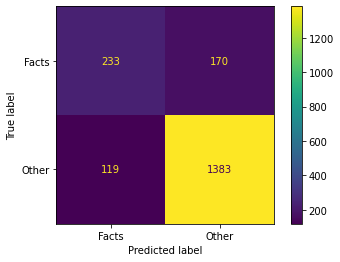

In [16]:
%%time
evaluate_with_test_set(default_mlp_trainer)

#### Linear SVM

In [17]:
from sklearn.svm import LinearSVC

def svm_trainer(X, y):
  svm = LinearSVC(random_state=1)
  return svm.fit(X, y)

In [18]:
%%time
cross_validation(svm_trainer)

### Evaluation with cross-validation ###
Starting fold 0


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 1


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 2


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 3


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Starting fold 4
Mean precision - std deviation => train: 0.8345 0.0351 	 test: 0.7110 0.0643
Mean recall - std deviation    => train: 0.7477 0.0610 	 test: 0.6244 0.0927
Mean f1 - std deviation        => train: 0.7858 0.0230 	 test: 0.6580 0.0470
CPU times: user 56.8 s, sys: 735 ms, total: 57.5 s
Wall time: 56.6 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### Evaluation with the test set ###


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Precision: 0.6800
Recall:    0.5484
F-score:   0.6071
CPU times: user 15 s, sys: 130 ms, total: 15.2 s
Wall time: 15 s


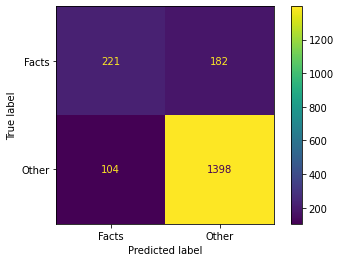

In [19]:
%%time
evaluate_with_test_set(svm_trainer)

#### RBF SVM

In [20]:
from sklearn.svm import SVC

def rbfsvm_trainer(X, y):
  rbfsvm = SVC(kernel='rbf', random_state=1)
  return rbfsvm.fit(X, y)

In [21]:
%%time

cross_validation(rbfsvm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7426 0.0190 	 test: 0.7328 0.0765
Mean recall - std deviation    => train: 0.5803 0.0200 	 test: 0.5928 0.0945
Mean f1 - std deviation        => train: 0.6511 0.0110 	 test: 0.6473 0.0568
CPU times: user 1min 53s, sys: 229 ms, total: 1min 53s
Wall time: 1min 52s


### Evaluation with the test set ###
Precision: 0.6076
Recall:    0.5186
F-score:   0.5596
CPU times: user 24 s, sys: 67.2 ms, total: 24.1 s
Wall time: 23.9 s


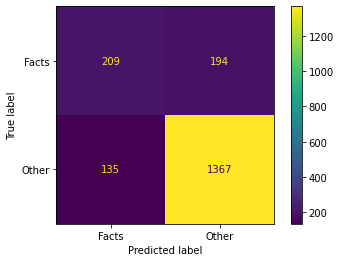

In [22]:
%%time

evaluate_with_test_set(rbfsvm_trainer)

#### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

def lr_trainer(X, y):
  logreg = LogisticRegression(solver='sag', max_iter=200, random_state=1)
  return logreg.fit(X, y)

In [24]:
%%time

cross_validation(lr_trainer)

### Evaluation with cross-validation ###
Starting fold 0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 3


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Starting fold 4
Mean precision - std deviation => train: 0.8133 0.0052 	 test: 0.7533 0.0544
Mean recall - std deviation    => train: 0.7146 0.0141 	 test: 0.6471 0.1006
Mean f1 - std deviation        => train: 0.7607 0.0101 	 test: 0.6884 0.0456
CPU times: user 1min 2s, sys: 679 ms, total: 1min 2s
Wall time: 1min 1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


### Evaluation with the test set ###


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Precision: 0.6685
Recall:    0.6154
F-score:   0.6408
CPU times: user 15.9 s, sys: 116 ms, total: 16 s
Wall time: 15.8 s


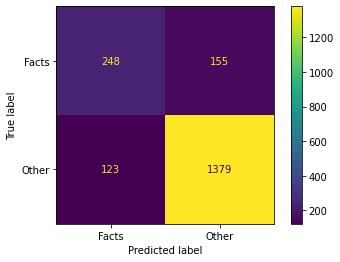

In [25]:
%%time

evaluate_with_test_set(lr_trainer)

#### KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

def knn_trainer(X, y):
  knn = KNeighborsClassifier(5)
  return knn.fit(X, y)

In [27]:
%%time

cross_validation(knn_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8168 0.0083 	 test: 0.7153 0.0809
Mean recall - std deviation    => train: 0.6384 0.0090 	 test: 0.5550 0.0911
Mean f1 - std deviation        => train: 0.7166 0.0054 	 test: 0.6153 0.0468
CPU times: user 29.7 s, sys: 4.06 s, total: 33.7 s
Wall time: 19.3 s


### Evaluation with the test set ###
Precision: 0.6246
Recall:    0.5161
F-score:   0.5652
CPU times: user 2.1 s, sys: 293 ms, total: 2.39 s
Wall time: 1.32 s


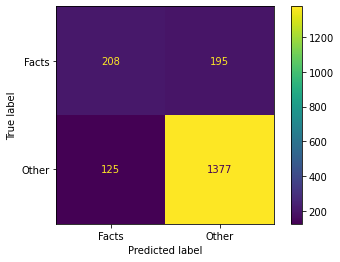

In [28]:
%%time

evaluate_with_test_set(knn_trainer)

#### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_trainer(X, y):
  dtree = DecisionTreeClassifier(random_state=1)
  return dtree.fit(X, y)

In [30]:
%%time

cross_validation(decision_tree_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 1.0000 0.0000 	 test: 0.5425 0.1022
Mean recall - std deviation    => train: 1.0000 0.0000 	 test: 0.5723 0.0587
Mean f1 - std deviation        => train: 1.0000 0.0000 	 test: 0.5481 0.0449
CPU times: user 1min 15s, sys: 124 ms, total: 1min 15s
Wall time: 1min 15s


### Evaluation with the test set ###
Precision: 0.4859
Recall:    0.5558
F-score:   0.5185


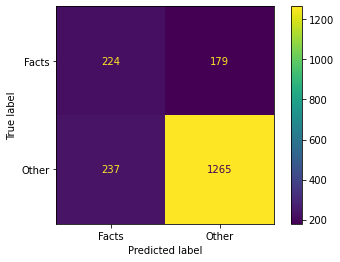

In [31]:
evaluate_with_test_set(decision_tree_trainer)

#### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_trainer(X, y):
  rforest = RandomForestClassifier(random_state=1)
  return rforest.fit(X, y)

In [33]:
cross_validation(random_forest_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 1.0000 0.0000 	 test: 0.7519 0.0669
Mean recall - std deviation    => train: 1.0000 0.0000 	 test: 0.6033 0.0959
Mean f1 - std deviation        => train: 1.0000 0.0000 	 test: 0.6616 0.0545


### Evaluation with the test set ###
Precision: 0.6520
Recall:    0.5533
F-score:   0.5987


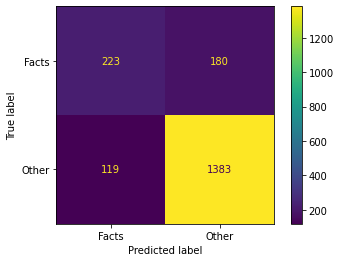

In [34]:
evaluate_with_test_set(random_forest_trainer)

#### AdaBoost

In [35]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_trainer(X, y):
  adab = AdaBoostClassifier(random_state=1)
  return adab.fit(X, y)

In [36]:
cross_validation(adaboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7798 0.0077 	 test: 0.6915 0.0643
Mean recall - std deviation    => train: 0.6934 0.0112 	 test: 0.6109 0.0812
Mean f1 - std deviation        => train: 0.7340 0.0097 	 test: 0.6419 0.0355


### Evaluation with the test set ###
Precision: 0.6379
Recall:    0.5682
F-score:   0.6010


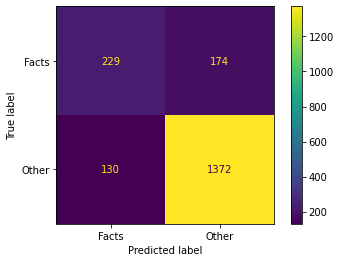

In [37]:
evaluate_with_test_set(adaboost_trainer)

#### Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_trainer(X, y):
  nb = GaussianNB()
  return nb.fit(X, y)


In [39]:
cross_validation(naive_bayes_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.4331 0.0362 	 test: 0.4308 0.0946
Mean recall - std deviation    => train: 0.8824 0.0081 	 test: 0.8829 0.0658
Mean f1 - std deviation        => train: 0.5800 0.0302 	 test: 0.5724 0.0782


### Evaluation with the test set ###
Precision: 0.3669
Recall:    0.7866
F-score:   0.5004


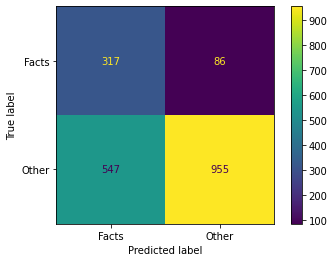

In [40]:
evaluate_with_test_set(naive_bayes_trainer)

#### XGBoost

In [41]:
from xgboost.sklearn import XGBClassifier
import torch

def xgboost_trainer(X, y):
  if torch.cuda.is_available():
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0)
  else:
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='hist')
  return xgboost.fit(X, y)


In [42]:
cross_validation(xgboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8718 0.0094 	 test: 0.7522 0.0504
Mean recall - std deviation    => train: 0.7516 0.0134 	 test: 0.6212 0.0996
Mean f1 - std deviation        => train: 0.8072 0.0111 	 test: 0.6734 0.0525


### Evaluation with the test set ###
Precision: 0.6685
Recall:    0.5906
F-score:   0.6271


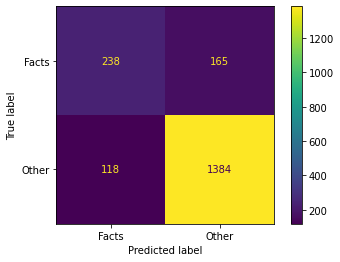

In [43]:
evaluate_with_test_set(xgboost_trainer)

### Results

In [44]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
for model_name, metrics in test_metrics.items():
  metrics_df.loc[model_name] = [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Precision,Recall,F1
MLPClassifier,0.6619,0.5782,0.6172
LinearSVC,0.6800,0.5484,0.6071
SVC,0.6076,0.5186,0.5596
LogisticRegression,0.6685,0.6154,0.6408
KNeighborsClassifier,0.6246,0.5161,0.5652
DecisionTreeClassifier,0.4859,0.5558,0.5185
RandomForestClassifier,0.6520,0.5533,0.5987
AdaBoostClassifier,0.6379,0.5682,0.6010
GaussianNB,0.3669,0.7866,0.5004
XGBClassifier,0.6685,0.5906,0.6271


### References:

- Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

- https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/